###Load Data


In [5]:
# http://stackoverflow.com/questions/31137552/unicodeencodeerror-ascii-codec-cant-encode-character-at-special-name
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import codecs
import json
import csv

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [6]:
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html
# Convert a JSON string to pandas object

X = pd.read_json('./pizza_request_dataset.json')
print ("type(X)", type(X))
print

# set random seed
np.random.seed(0)

# randomly assign 70% to train_data, and 30% to dev_data
msk = np.random.rand(len(X)) <= 0.7
train_data = X[msk]
dev_data = X[~msk]

# create output dataframe Y of train_labels
train_labels = train_data[["requester_received_pizza"]]

# delete train_labels from input dataframe of train_data
del train_data["requester_received_pizza"]

# create output dataframe of dev_labels
dev_labels = dev_data[["requester_received_pizza"]]

# delete dev_labels from input dataframe of dev_data
del dev_data["requester_received_pizza"]

# print (labels, shapes, and feature names
print ("train_labels" )
print ("----------")
print (list(train_labels))
print (train_labels.shape), "/n"
print ("train_data" )
print ("----------")
print (list(train_data))
print (train_data.shape), "/n"


print ("dev_labels") 
print ("----------")
print (list(dev_labels))
print (dev_labels.shape), "/n"

print ("dev_data")
print ("----------")
print (list(dev_data))
print (dev_data.shape), "/n"

# print (percent of train_data and dev_data whose posts led to receipt of pizza
print ("train labels")
print ("----------")
print (np.mean(train_labels)), "/n"
print ("dev labels")
print ("----------")
print (np.mean(dev_labels))

##Extract text and tile for train and dev

In [7]:
train_text=train_data['request_text'].as_matrix()
train_title=train_data['request_title'].as_matrix()
# train_all = train_text+train_title

dev_text=dev_data['request_text'].as_matrix()
dev_title=dev_data['request_title'].as_matrix()
# dev_all = dev_text+dev_title

'''
train_text = [x.encode('utf-8') if isinstance(x, unicode) else x for x in train_text]

dev_text = [x.encode('utf-8') if isinstance(x, unicode) else x for x in dev_text]
'''

# train_all=train_all.reshape(3975,1)
# dev_all=dev_all.reshape(len(dev_all),1)

"\ntrain_text = [x.encode('utf-8') if isinstance(x, unicode) else x for x in train_text]\n\ndev_text = [x.encode('utf-8') if isinstance(x, unicode) else x for x in dev_text]\n"

In [8]:
# print(train_all.shape)
# print(dev_all.shape)
# print(train_all[1])
# print(train_text.shape)
train_all=np.empty((len(train_text),2),dtype=str)
train_all[:,0]=train_text
train_all[:,1]=train_title

dev_all=np.empty((len(dev_text),2),dtype=str)
dev_all[:,0]=dev_text
dev_all[:,1]=dev_title


In [9]:
print(train_all.shape)
print(dev_all.shape)
print(train_text[0])

####helper method

In [10]:
#Roc curve:
from sklearn.metrics import roc_curve, auc

def model_output(pred_probas, F_Score, preds):

    print ("Logistic regression on numeric data: F-Score = %0.4f: "%(F_Score) ) #Sum up Squared Weights
    accuracy = np.where(preds==np.ravel(dev_labels), 1, 0).sum() / float(len(dev_labels))
    print ("Accuracy = %0.4f" % (accuracy))
    print ('accuracy_score: %f' %metrics.precision_score(dev_labels, preds))
    print ('recall_score: %f' %metrics.recall_score(dev_labels, preds))
    print ("roc_auc_score:", metrics.roc_auc_score(dev_labels, preds))

#Create ROC Curve

    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    print('auc: %.4f' %roc_auc)
    
    plt.show()

###Test the base model

##Text

In [11]:

def first_preprocessor(s):
### STUDENT START ###
    
    # use regular expressions to find-and-replace and normalize the input
    # http://regexr.com/
    
    # make all text lowercase
    s = s.lower()
    
    # replace digit(s) with an uncommon string,'zz'
    s = re.sub("\d+", "zz", s)
    
    # stem words with specific endings
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)

    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    
    #-----
    # write variation of code, but remove ending s (make plural words singular)
    # http://stackoverflow.com/questions/3675318/how-to-replace-the-some-characters-from-the-end-of-a-string
    def replace_ending_s(orig_string):
        head, sep, tail = orig_string.rpartition("s")
        if orig_string[len(orig_string)-1] in ("s"):
            return head
        else:
            return orig_string
    
    '''
    # test out replace_ending_s
    
    a = "1231s5"
    b = "1231es"

    print replace_ending_s(a)
    print replace_ending_s(b)
    '''
    
    if len(s) >= 3:
        s = replace_ending_s(s)
    #----- 
    
    # replace 2-3 blank spaces with 1 blank space
    s = re.sub("   ", " ", s)
    s = re.sub("  ", " ", s)
    
    #-----
    # comment out ones below that didn't seem to help
      
    #remove punctation
    #s=re.sub("[,.!?:;/~*]"," ",s)
    #remove duplicated 0s and 1s
    #s=re.sub("[0-9]*","",s)
    
    # replace all non-alphanumeric characters with a space
    # http://stackoverflow.com/questions/2779453/python-strip-everything-but-spaces-and-alphanumeric
    # s = re.sub("\W+", " ", s)
    #s = re.sub(r'([^\s\w]|_)+', " ", s)

    '''
    s = re.sub("ing", "", s)
    s = re.sub("ion", "", s)
    s = re.sub("ly", "", s)
    s = re.sub("ness", "", s)
    #s = re.sub("ies", "y", s)
    #s = re.sub("ment", "", s)
    #s = re.sub("or", "", s) 
    '''
    
    #s=re.sub("'ll"," ",s)
    #s=re.sub("'ve"," ",s)
    #s=re.sub("'m"," ",s)

    # find anything that is NOT a lowercase letter (a-z) or an upper case letter (A-Z), and replace with a space
    #s = re.sub("[^a-zA-Z]", " ", s)
    
    # truncate words to 5 characters or less
    #s = s[:5]
    
    '''
    # remove some stop_word tokens
    for stop_word in ("and", "has", "have", "is", "was", "in", "of", "on", "the"):
        s = re.sub(stop_word, "", s)
    '''
    #-----
    
    # return preprocessed string
    return s

In [12]:
# pull select ones below and place above
'''
def first_preprocessor(s):
    #convert to lowercase
    s=s.lower()
    s=re.sub("[,.!?:;/~*]"," ",s)
    #remove duplicated 0s and 1s
    s=re.sub("[0-9]*","",s)
    #remove number longer than 5 digit
    s=re.sub("[0-9]{5,}","",s)
    #remove stem end with 'ly'
    s=re.sub("ly\s"," ",s)
    #remove plural form
    s=re.sub("s\s"," ",s)
    s=re.sub("s\Z"," ",s)
    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    #remove stem end with 'ness'
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)
    #remove words that are too short
    s=re.sub("\s[0-9a-z]{1,2}\s"," ",s)
    s=re.sub("\s[0-9a-z]{1,2}\Z"," ",s)
'''

'\ndef first_preprocessor(s):\n    #convert to lowercase\n    s=s.lower()\n    s=re.sub("[,.!?:;/~*]"," ",s)\n    #remove duplicated 0s and 1s\n    s=re.sub("[0-9]*","",s)\n    #remove number longer than 5 digit\n    s=re.sub("[0-9]{5,}","",s)\n    #remove stem end with \'ly\'\n    s=re.sub("ly\\s"," ",s)\n    #remove plural form\n    s=re.sub("s\\s"," ",s)\n    s=re.sub("s\\Z"," ",s)\n    #remove _ as the end of word\n    s=re.sub("[_]+"," ",s)\n    #remove _ as start of the word\n    s=re.sub("\\s[_]+"," ",s)\n    #remove stem end with \'ness\'\n    s=re.sub("ness\\s"," ",s)\n    s=re.sub("ing\\s"," ",s)\n    #remove words that are too short\n    s=re.sub("\\s[0-9a-z]{1,2}\\s"," ",s)\n    s=re.sub("\\s[0-9a-z]{1,2}\\Z"," ",s)\n'

In [13]:
def train_log(train, dev):
    
    model_LG_func = LogisticRegression(penalty ='l2',C=13)
    model_LG_func.fit(train, np.ravel(train_labels))

#     print('f1_score: %f' %metrics.f1_score(dev_labels,train.predict(dev),average='binary'))
#     print('precision_score: %f' %metrics.precision_score(dev_labels,train.predict(dev)))
#     print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev)))
#     print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

    preds = model_LG_func.predict(dev)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_func.predict_proba(dev)

    #Call to display outputs
    model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    print(roc_auc)

###CountVector

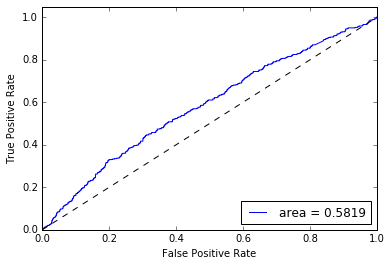

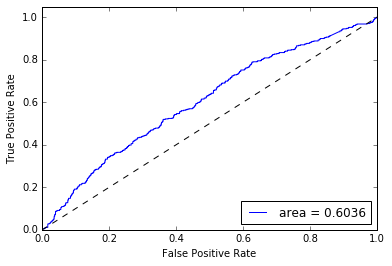

In [14]:
def empty_preprocessor(s):
    return s

vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='char',stop_words='english')
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
print('WIthout word prprocessing:\n')
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = CountVectorizer(preprocessor =first_preprocessor,analyzer='char',stop_words='english')
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
print('WIth word prprocessing:\n')
train_log(train_matrix_process_text,dev_matrix_process_text)

# model_LG = LogisticRegression(penalty ='l2',C=12)
# model_LG.fit(train_matrix_process_text, np.ravel(train_labels))

# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

# preds = model_LG.predict(dev_matrix_process_text)
# F_Score = metrics.f1_score(dev_labels, preds, average='binary')
# pred_probas = model_LG.predict_proba(dev_matrix_process_text)

# #Call to display outputs
# model_output(pred_probas, F_Score, preds)



##TF-IDF

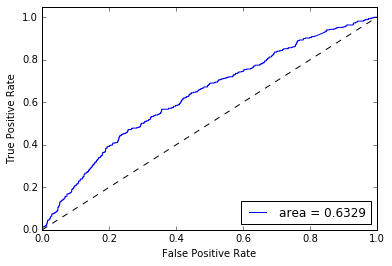

In [15]:
def empty_preprocessor(s):
    return s


vectorizer_process = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8))
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)

train_log(train_matrix_process_text,dev_matrix_process_text)

# vectorizer_process = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
# train_matrix_process_text= vectorizer_process.fit_transform(train_text)
# dev_matrix_process_text = vectorizer_process.transform(dev_text)

# train_log(train_matrix_process_text,dev_matrix_process_text)

# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

# preds = model_LG.predict(dev_matrix_process_text)
# F_Score = metrics.f1_score(dev_labels, preds, average='binary')
# pred_probas = model_LG.predict_proba(dev_matrix_process_text)

# #Call to display outputs
# model_output(pred_probas, F_Score, preds)
# fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
# roc_auc = metrics.auc(fpr,tpr)
# print(roc_auc)

###take a look at the top cofficient words

In [16]:
from sklearn.decomposition import PCA

#------
# use for this cell
model_LG = LogisticRegression(penalty ='l2',C=1)
model_LG.fit(train_matrix_process_text, np.ravel(train_labels))
#------

print(model_LG.coef_.shape)
# print( abs(model_LG.coef_ [0]))
# print(len(vectorizer_process.vocabulary_))
# print(vectorizer_process.vocabulary_)

model_LG = LogisticRegression(penalty ='l2',C=0.08)
model_LG.fit(train_matrix_process_text, np.ravel(train_labels))

index_good=np.argsort((model_LG.coef_ [0]))[-200:]

df = pd.DataFrame({'Feature': np.array(vectorizer_process.get_feature_names())[index_good], 'coef': np.array(model_LG.coef_ [0])[index_good]})
print(df)

index_bad=np.argsort((model_LG.coef_ [0]))[:200]

df = pd.DataFrame({'Feature': np.array(vectorizer_process.get_feature_names())[index_bad], 'coef': np.array(model_LG.coef_ [0])[index_bad]})
print(df)

'''
pca1 = PCA(n=440)      
pca1.fit(train_matrix_process_text)   
print ("all components, pct variance explained =", sum(pca1.explained_variance_ratio_))
'''

# a=np.concatenate((np.array(vectorizer_process.get_feature_names())[index],np.array(model_LG.coef_ [0])[index]), axis=0)
# a= np.array(vectorizer_process.get_feature_names())[index]+np.array(model_LG.coef_ [0])[index]
# print(a)

'\npca1 = PCA(n=440)      \npca1.fit(train_matrix_process_text)   \nprint ("all components, pct variance explained =", sum(pca1.explained_variance_ratio_))\n'

##Try to find the best number of words to include in the model

In [17]:
def empty_preprocessor(s):
    return s

def train_tf_idf(dicts):
    
    vectorizer_process_limit = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8),vocabulary=dicts )
    train_matrix_process_text= vectorizer_process_limit.fit_transform(train_text)
    dev_matrix_process_text = vectorizer_process_limit.transform(dev_text)


    model_LG_limit = LogisticRegression(penalty ='l2',C=13)
    model_LG_limit.fit(train_matrix_process_text, np.ravel(train_labels))

    # print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
    # print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

    preds = model_LG_limit.predict(dev_matrix_process_text)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_limit.predict_proba(dev_matrix_process_text)

    #Call to display outputs
#     model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    return roc_auc

In [18]:
auc=[]
idx=[]
for i in range(100,4000,40):
    index_good=np.argsort((model_LG.coef_ [0]))[-i:]
    index_bad=np.argsort((model_LG.coef_ [0]))[:i]
    dicts=[]
    dicts=list(np.array(vectorizer_process.get_feature_names())[index_good])+list(np.array(vectorizer_process.get_feature_names())[index_bad])
    auc.append(train_tf_idf(dicts))
    idx.append(i)


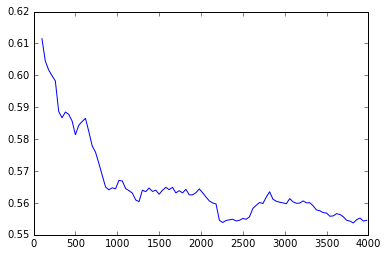

In [19]:
plt.plot(idx,auc)
# plt.show()
print(np.argsort(auc))
print(idx[3])
print(auc[3])

print("done")

####given the best number of words to include is 220, i picked the top 220 words from each side

In [20]:
for i in [220]:
    index_good=np.argsort((model_LG.coef_ [0]))[-i:]
    index_bad=np.argsort((model_LG.coef_ [0]))[:i]
    dicts=[]
    dicts=list(np.array(vectorizer_process.get_feature_names())[index_good])+list(np.array(vectorizer_process.get_feature_names())[index_bad])
    vectorizer_process_limit = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8),vocabulary=dicts )
    train_matrix_process_text= vectorizer_process_limit.fit_transform(train_text)
    dev_matrix_process_text = vectorizer_process_limit.transform(dev_text)

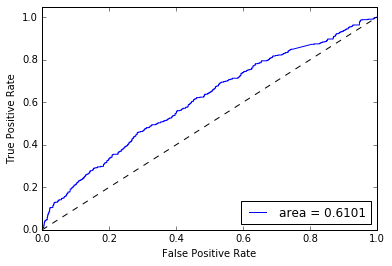

In [21]:
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_matrix_process_text
b=dev_matrix_process_text

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

##Narrative

In [169]:
desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving|gf)', re.IGNORECASE)
family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter|firstborn|Pregnancy  )', re.IGNORECASE)
job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work)', re.IGNORECASE)
money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
mood = re.compile(r'(thank|thanks|thankful|appreciate|grateful|gratitude|advance)', re.IGNORECASE) 
holiday = re.compile(r'(anniversary|chirstmas)', re.IGNORECASE)   


In [170]:
def myfunc(a,b):
    if len(a)==0:
        return 0 
    else:
        return len(b.findall(a))/float(len(a))


In [171]:
narrative_all=np.ndarray(shape=(len(train_text),7),dtype=int)
narrative_all_dev=np.ndarray(shape=(len(dev_text),7),dtype=int)

for index,i in enumerate([desire,family,job,money,student,mood,holiday]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_title,i)
    narrative_dev=vfunc(dev_title,i)
    narrative_max=np.amax(narrative)
    narrative_all[:,index]=np.where(narrative>narrative_max-2,1,0)
    narrative_all_dev[:,index]=np.where(narrative_dev>narrative_max-2,1,0)
#     narrative_all[:,index]=narrative
#     narrative_all_dev[:,index]=narrative_dev

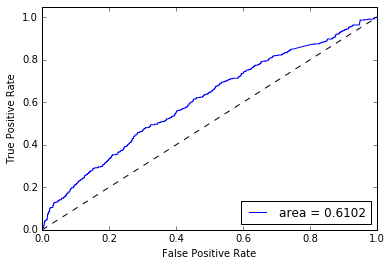

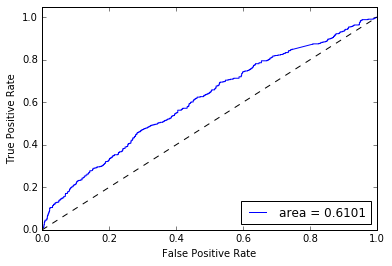

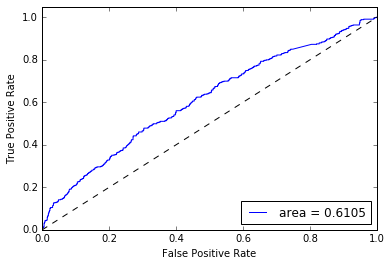

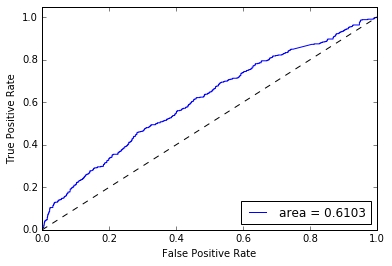

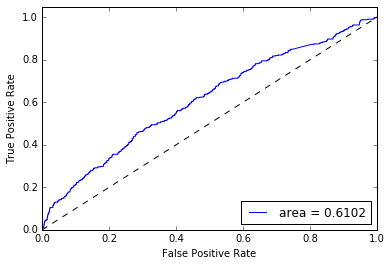

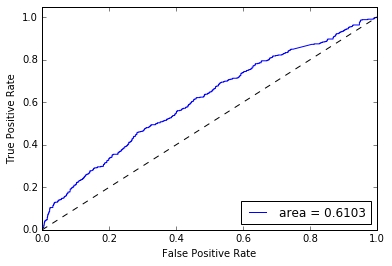

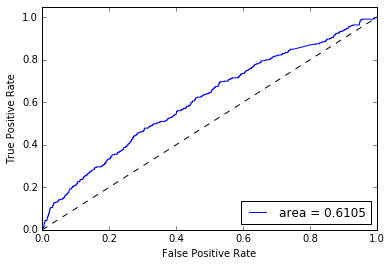

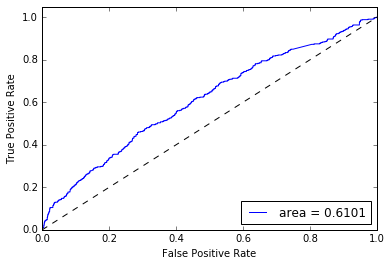

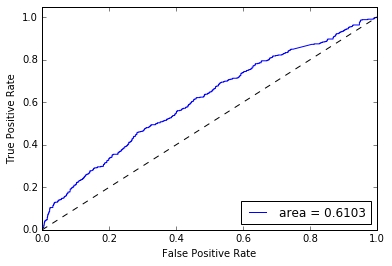

In [173]:
train_narrative=np.concatenate((train_matrix_process_text.toarray(), narrative_all), axis=1)
dev_narrative=np.concatenate((dev_matrix_process_text.toarray(), narrative_all_dev), axis=1)

print(train_narrative.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative
b=dev_narrative

#print ("1", model_LG_L1.coef_)

for c in [.01, .013, .015, .017, .1, .2, .3, .4, .5]:

    model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
    model_LG_L1.fit(a, np.ravel(train_labels))

    #Update the new index
    index=[]
    for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
        if z!=0:
            index.append(i)

    #print ("2", index)

    model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
    model_LG.fit(a[:,index], np.ravel(train_labels))

    preds = model_LG.predict(b[:,index])
    F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
    pred_probas = model_LG.predict_proba(b[:,index])

    #Call to display outputs
    model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    print (roc_auc)

##excl_marks


In [27]:
exclmarks = re.compile(r'(!)', re.M)
# holiday    = re.compile(r'(anniversary|chirstmas)', re.IGNORECASE)   
excl_marks=np.ndarray(shape=(len(train_text),1),dtype=int)
excl_marks_dev=np.ndarray(shape=(len(dev_text),1),dtype=int)

for index,i in enumerate([exclmarks]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_title+train_text,i)
    narrative_dev=vfunc(dev_title+dev_text,i)
#     med=np.median(narrative)
    excl_marks[:,index]=np.where(narrative>0,1,0)
    excl_marks_dev[:,index]=np.where(narrative_dev>0,1,0)

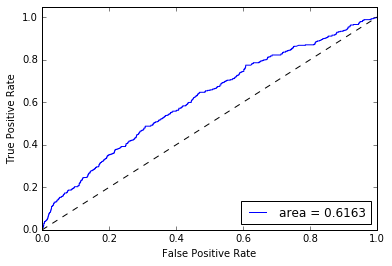

In [28]:
train_narrative_excl=np.concatenate((train_narrative, excl_marks), axis=1)
dev_narrative_excl=np.concatenate((dev_narrative, excl_marks_dev), axis=1)
print(train_narrative_excl.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl
b=dev_narrative_excl

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#print ("1", model_LG_L1.coef_)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
#print ("2", index)
            
model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

In [29]:
train_caps = train_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()
dev_caps = dev_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()


In [30]:
train_caps=train_caps.reshape(len(train_caps),1) 
dev_caps=dev_caps.reshape(len(dev_caps),1) 
# train_narrative_excl_cap.shape
# train_cap.shape
# train_narrative_excl_cap.shape

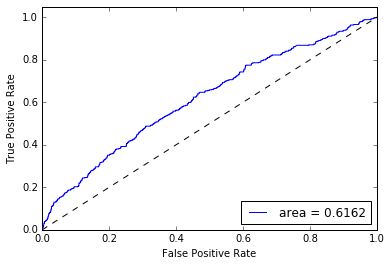

In [31]:
train_narrative_excl_cap=np.concatenate((train_narrative_excl, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative_excl, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl_cap
b=dev_narrative_excl_cap

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#print ("1", model_LG_L1.coef_)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

#print ("2", index)

model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

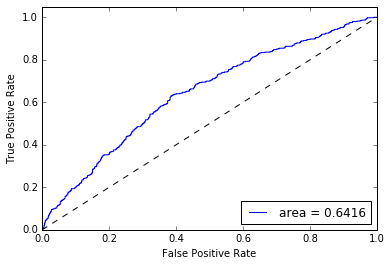

In [175]:
=np.concatenate((train_narrative_excl, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative_excl, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl_cap
b=dev_narrative_excl_cap

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=0.26)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs

fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)


###narrative

In [184]:
desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving)', re.IGNORECASE)
family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter)', re.IGNORECASE)
job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work|paycheck)', re.IGNORECASE)
money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
mood = re.compile(r'(thank|nice|like|best|great|surprise)', re.IGNORECASE) 

combo = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving|\
husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter|job|unemployment|employment|hire|hired|fired|interview|work|paycheck|\
money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|\
years|never|till|yesterday|morning|evening|college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm|\
thank|nice|like|best|great|surprise)', re.IGNORECASE) 

# https://github.com/stevenzim/Pizza/blob/master/raop/featureextract/featureextract.py

# Count the number of terms in different kinds of stories using regular expression: Money1 Money2 Job Family
# As suggested on http://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf

money1_regex = re.compile(r"(week|ramen|paycheck|work|couple|rice|check|pizza|grocery|rent|anyone|favor|someone|bill|money)", re.IGNORECASE)
money2_regex = re.compile(r"(food|money|house|bill|rent|stamp|month|today|parent|help|pizza|someone|anything|mom|anyone)", re.IGNORECASE)
job_regex = re.compile(r"(job|month|rent|year|interview|bill|luck|school|pizza|paycheck|unemployment|money|ramen|end|check)", re.IGNORECASE)
family_regex = re.compile(r"(tonight|night|today|tomorrow|someone|anyone|friday|dinner|something|account|family|bank|anything|home|work)", re.IGNORECASE)

In [185]:
def myfunc(a,b):
    if len(a)==0:
        return 0 
    else:
        return len(b.findall(a))/float(len(a))



In [194]:
narrative_all=np.ndarray(shape=(len(train_all),5),dtype=int)
narrative_all_dev=np.ndarray(shape=(len(dev_all),5),dtype=int)

for index,i in enumerate([desire,family,job,money,student]):
#for index,i in enumerate([money1_regex, money2_regex, family, job]):
#for index,i in enumerate([combo]):
    '''
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_all,i)
    narrative_dev=vfunc(dev_all,i)
    med=np.median(narrative)
    narrative_all[:,index]=np.where(narrative>med,1,0)
    narrative_all_dev[:,index]=np.where(narrative_dev>med,1,0)
    '''
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_all,i)
    narrative_dev=vfunc(dev_all,i)
    narrative_max=np.amax(narrative)
    narrative_all[:,index]=np.where(narrative>=narrative_max-2,1,0)
    narrative_all_dev[:,index]=np.where(narrative_dev>=narrative_max-2,1,0)


In [195]:


# np.hstack((word_matrix_process, narrative_all))
# word_matrix_process+narrative_all
a=np.concatenate((train_narrative_excl_cap, narrative_all), axis=1)
b=np.concatenate((dev_narrative_excl_cap, narrative_all_dev), axis=1)

In [196]:
print(train_matrix_process_text.shape) 
print(dev_matrix_process_text.shape) 
print(a.shape) 
print(b.shape) 

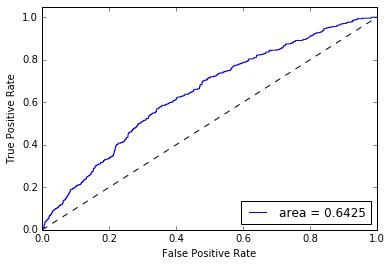

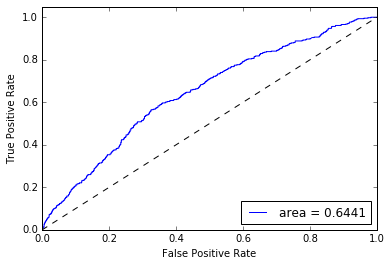

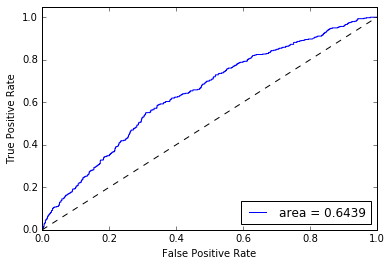

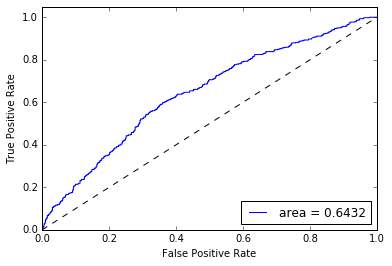

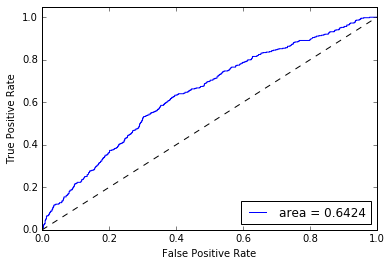

In [197]:
def empty_preprocessor(s):
    return s


# vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

# a=np.concatenate((word_matrix_process.toarray(), narrative_all), axis=1)
# b=np.concatenate((dev_matrix_process.toarray(), narrative_all_dev), axis=1)

#for c in [.01, .013, .015, .017, .1, .2, .3, .4, .5, 1, 5]:
for c in [.1, .15, .2, .25, .3]:
    model_LG = LogisticRegression(penalty ='l2',C=c)
    model_LG.fit(a, np.ravel(train_labels))

    preds = model_LG.predict(b)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG.predict_proba(b)

    #Call to display outputs
    model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    print (roc_auc)